# Preparation

<b>Load Libraries</b>

In [39]:
# data structures
import numpy as np
import pandas as pd

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns
## settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_theme('notebook')

# normality test 
from scipy.stats import kstest, normaltest, shapiro

# dependence test
from scipy.stats import chi2_contingency

# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# outliers
from scipy.stats import zscore

<b>Load Dataset</b>

In [2]:
# dataset
df_base = pd.read_csv('../../dataset/raw/train.csv')

## dtype separation
num_cols = df_base.select_dtypes(np.number).columns.tolist()
cat_cols = df_base.select_dtypes('object').columns.tolist()

## clone
df_cleaned = df_base.copy()

<b>User-Defined Functions</b>

In [37]:
# normality test
def normality_test(df: pd.DataFrame, num_names: list) -> pd.DataFrame:
    ##
    test_names, statistics = ['Kolmogorov-Smirnov', 'D\'Agostino-Pearson\'s', 'Shapiro-Wilk'], ['statistic', 'pvalue']
    idx = pd.MultiIndex.from_product(
        [test_names, statistics]
    )

    ##
    statistics, pvalues = kstest(
        rvs=df[num_names],
        cdf='norm', 
        axis=0
    )
    res = np.vstack(
        tup=[statistics, pvalues]
    )

    ##
    statistics, pvalues = normaltest(
        a=df[num_names],
        axis=0
    )
    res = np.vstack(
        tup=[res, statistics, pvalues]
    )

    ##
    statistics, pvalues = shapiro(
        x=df[num_names], 
        axis=0
    )
    res = np.vstack(
        tup=[res, statistics, pvalues]
    )
    
    ##
    res = pd.DataFrame(
        data=res, 
        index=idx, columns=num_names
    )
    res.index.names = ['test', 'statistics']

    ##
    for name in test_names:
        mask = res.xs(
            key=(name, 'pvalue'),
            axis=0, 
            level=['test', 'statistics']
        )\
            .values.ravel() > 0.05
        print(f'{name}: \n{np.array(num_names)[mask]}')

    return res

In [4]:
# dependency test: chi-square
def chi2(df: pd.DataFrame, cat_names: list):
    ##
    num_iters = len(cat_names)
    pvalues = np.zeros((num_iters, num_iters))

    ##
    i = 1
    while i < num_iters:
        for j in range(i):
            cross_tab = pd.crosstab(
                index=df[cat_names[i]], 
                columns=df[cat_names[j]]
            )\
                .values
            _, pvalue, _, _ = chi2_contingency(observed=cross_tab)

            if pvalue <= 0.05:
                print(f'{cat_names[i]} ~ {cat_names[j]}: {pvalue}')
            pvalues[i, j] = pvalue

        i += 1

    ##
    res = pd.DataFrame(
        data=pvalues, 
        index=cat_names, columns=cat_names
    )
    mask = np.triu(np.ones_like(pvalues, dtype=bool))
    g = sns.heatmap(
        data=res, 
        vmin=0, vmax=1, 
        mask=mask, cmap='Set2', linewidths=1.5, 
        annot=True, fmt='.3f'
    )
    g.axes.tick_params(axis='x', rotation=45)
    plt.show(g)

In [5]:
# dependency test: permutation test
def permutation(df: pd.DataFrame, cat_names: list, num_names: list):
    num_num_iters, num_cat_iters = len(num_names), len(cat_names)
    pvalues = np.zeros((num_cat_iters, num_num_iters))

    for i in range(num_cat_iters):
        for j in range(num_num_iters):
            ###
            obs_var = df.groupby([cat_names[i]], observed=True)[num_names[j]]\
                .std().var()
            
            ###
            perm_vars = [
                pd.Series(
                    data=np.random.permutation(df[num_names[j]].values),
                    index=df[cat_cols[i]]
                )\
                    .groupby(cat_cols[i], observed=True)\
                        .std().var()

                for _ in np.arange(1000)
            ]

            ###
            pvalue = np.mean(np.array(perm_vars) > obs_var)
            if pvalue < 0.05:
                print(f'{cat_cols[i]} ~ {num_cols[j]}: {pvalue}')
            pvalues[i, j] = pvalue

    ##
    res = pd.DataFrame(
        data=pvalues, 
        index=cat_names, columns=num_names
    )
    fig, ax = plt.subplots()
    fig.set_figwidth(15), fig.set_figheight(10)
    g = sns.heatmap(
        data=res, 
        vmin=0, vmax=1,
        annot= True, fmt='.3f', 
        linewidths=1.5,
        cmap='Set2', 
        ax=ax
    )
    plt.show(g)

In [6]:
# VIF
def compute_vif(df: pd.DataFrame, num_names: list) -> pd.Series:
    X = df[num_names].values
    vif = [
        variance_inflation_factor(
            exog=X,
            exog_idx=i
        )
        for i in range(len(num_names))
    ]
    vif = pd.DataFrame(
        data={
            'name': num_names,
            'vif': vif
        }
    )

    return vif

# Data Wrangling

<b>Peek at Data</b>

In [7]:
# shape
df_base.shape

(4250, 20)

In [8]:
# head
df_base.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [9]:
# tail
df_base.tail()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
4245,MT,83,area_code_415,no,no,0,188.3,70,32.01,243.8,88,20.72,213.7,79,9.62,10.3,6,2.78,0,no
4246,WV,73,area_code_408,no,no,0,177.9,89,30.24,131.2,82,11.15,186.2,89,8.38,11.5,6,3.11,3,no
4247,NC,75,area_code_408,no,no,0,170.7,101,29.02,193.1,126,16.41,129.1,104,5.81,6.9,7,1.86,1,no
4248,HI,50,area_code_408,no,yes,40,235.7,127,40.07,223.0,126,18.96,297.5,116,13.39,9.9,5,2.67,2,no
4249,VT,86,area_code_415,no,yes,34,129.4,102,22.00,267.1,104,22.70,154.8,100,6.97,9.3,16,2.51,0,no


In [10]:
# info
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

<b>Redundant Columns</b>

In [11]:
# low variance
df_base.nunique()

state                              51
account_length                    215
area_code                           3
international_plan                  2
voice_mail_plan                     2
number_vmail_messages              46
total_day_minutes                1843
total_day_calls                   120
total_day_charge                 1843
total_eve_minutes                1773
total_eve_calls                   123
total_eve_charge                 1572
total_night_minutes              1757
total_night_calls                 128
total_night_charge                992
total_intl_minutes                168
total_intl_calls                   21
total_intl_charge                 168
number_customer_service_calls      10
churn                               2
dtype: int64

<b>Format Adjustments</b>

In [12]:
# stripping
for name in cat_cols:
    df_cleaned[name] = df_base[name].astype(str).str.strip() 

##
df_cleaned.columns = [name.strip() for name in df_base.columns.tolist()]
num_cols = df_cleaned.select_dtypes(np.number).columns.tolist()
cat_cols = df_cleaned.select_dtypes('object').columns.tolist()

In [13]:
# null strings
mask = df_base[cat_cols] == ''
counts = mask.sum(axis=0)
print(f'Total null strings per column: \n{counts}')

Total null strings per column: 
state                 0
area_code             0
international_plan    0
voice_mail_plan       0
churn                 0
dtype: int64


In [14]:
# spelling
for name in cat_cols:
    print(f'{name}: {df_cleaned[name].unique()}')

## 
df_cleaned['area_code'] = df_cleaned['area_code'].str.split('_').str[-1]

state: ['OH' 'NJ' 'OK' 'MA' 'MO' 'LA' 'WV' 'IN' 'RI' 'IA' 'MT' 'NY' 'ID' 'VA'
 'TX' 'FL' 'CO' 'AZ' 'SC' 'WY' 'HI' 'NH' 'AK' 'GA' 'MD' 'AR' 'WI' 'OR'
 'MI' 'DE' 'UT' 'CA' 'SD' 'NC' 'WA' 'MN' 'NM' 'NV' 'DC' 'VT' 'KY' 'ME'
 'MS' 'AL' 'NE' 'KS' 'TN' 'IL' 'PA' 'CT' 'ND']
area_code: ['area_code_415' 'area_code_408' 'area_code_510']
international_plan: ['no' 'yes']
voice_mail_plan: ['yes' 'no']
churn: ['no' 'yes']


<b>Dtypes Conversion</b>

In [15]:
# conversion
df_cleaned[num_cols] = df_cleaned[num_cols].astype('float64')
df_cleaned[cat_cols] = df_cleaned[cat_cols].astype('category')

<b>Duplications</b>

In [16]:
# counts
mask = df_cleaned.duplicated()
counts = mask.sum()
print(f'Total duplications: \n{counts}')

Total duplications: 
0


<b>Missing Values</b>

In [17]:
# counts
mask = df_cleaned.isnull()
counts = mask.sum(axis=0)
print(f'Total null values per columns: \n{counts}')

Total null values per columns: 
state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64


<b>Hypothesis Tests</b>

In [38]:
# normality test
## Null hypothesis: Data are normally distributed
res = normality_test(df_cleaned, num_cols)
res

Kolmogorov-Smirnov: 
[]
D'Agostino-Pearson's: 
['total_day_minutes' 'total_day_charge' 'total_eve_minutes'
 'total_eve_calls' 'total_eve_charge' 'total_night_minutes'
 'total_night_calls' 'total_night_charge']
Shapiro-Wilk: 
['total_day_minutes' 'total_day_charge' 'total_eve_minutes'
 'total_eve_charge' 'total_night_minutes' 'total_night_calls'
 'total_night_charge']


account_length  number_vmail_messages  \
test                 statistics                                          
Kolmogorov-Smirnov   statistic         0.996532           5.000000e-01   
                     pvalue            0.000000           0.000000e+00   
D'Agostino-Pearson's statistic        13.980513           8.020275e+02   
                     pvalue            0.000921          6.949409e-175   
Shapiro-Wilk         statistic         0.997968           6.060898e-01   
                     pvalue            0.000023           2.321285e-71   

                                 total_day_minutes  total_day_calls  \
test                 statistics                                       
Kolmogorov-Smirnov   statistic            0.999294         0.999529   
                     pvalue               0.000000         0.000000   
D'Agostino-Pearson's statistic            0.583675        10.955972   
                     pvalue               0.746890         0.004178   
Shapiro-Wilk         statistic            0.999613         0.998365   
                     pvalue               0.599524         0.000227   

                                 total_day_charge  total_eve_minutes  \
test                 statistics                                        
Kolmogorov-Smirnov   statistic           0.998348           0.999765   
                     pvalue              0.000000           0.000000   
D'Agostino-Pearson's statistic           0.581075           1.022619   
                     pvalue              0.747861           0.599710   
Shapiro-Wilk         statistic           0.999613           0.999584   
                     pvalue              0.599739           0.526558   

                                 total_eve_calls  total_eve_charge  \
test                 statistics                                      
Kolmogorov-Smirnov   statistic          0.999765          0.999094   
                     pvalue             0.000000          0.000000   
D'Agostino-Pearson's statistic          2.511838          1.019556   
                     pvalue             0.284814          0.600629   
Shapiro-Wilk         statistic          0.998972          0.999584   
                     pvalue             0.010841          0.526054   

                                 total_night_minutes  total_night_calls  \
test                 statistics                                           
Kolmogorov-Smirnov   statistic              0.999765           0.999765   
                     pvalue                 0.000000           0.000000   
D'Agostino-Pearson's statistic              2.264473           1.080098   
                     pvalue                 0.322312           0.582720   
Shapiro-Wilk         statistic              0.999679           0.999210   
                     pvalue                 0.771238           0.053777   

                                 total_night_charge  total_intl_minutes  \
test                 statistics                                           
Kolmogorov-Smirnov   statistic             0.994285        9.905754e-01   
                     pvalue                0.000000        0.000000e+00   
D'Agostino-Pearson's statistic             2.264331        9.026337e+01   
                     pvalue                0.322334        2.509336e-20   
Shapiro-Wilk         statistic             0.999676        9.931052e-01   
                     pvalue                0.764482        1.888362e-13   

                                 total_intl_calls  total_intl_charge  \
test                 statistics                                        
Kolmogorov-Smirnov   statistic       9.188969e-01       8.911842e-01   
                     pvalue          0.000000e+00       0.000000e+00   
D'Agostino-Pearson's statistic       1.110411e+03       9.040416e+01   
                     pvalue         7.539090e-242       2.338764e-20   
Shapiro-Wilk         statistic       9.022262e-01       9.930829e-01   
                     pvalue

churn ~ state: 0.0011690284839826976
churn ~ international_plan: 1.9831895448817517e-63
churn ~ voice_mail_plan: 1.139803854851859e-13


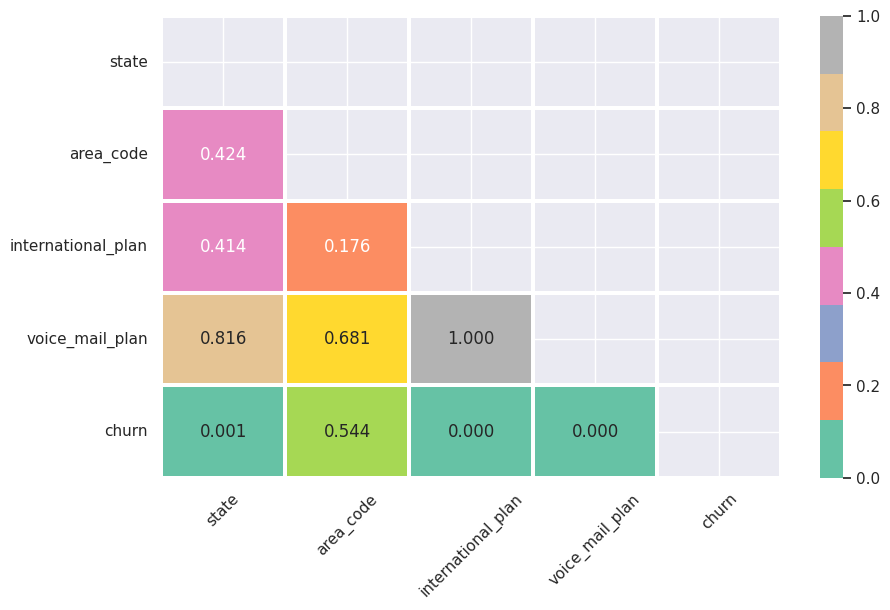

In [19]:
# dependecy test: chi-square
chi2(df_cleaned, cat_cols)

state ~ total_intl_calls: 0.039
voice_mail_plan ~ number_vmail_messages: 0.0
churn ~ number_vmail_messages: 0.0
churn ~ total_day_minutes: 0.0
churn ~ total_day_calls: 0.028
churn ~ total_day_charge: 0.0
churn ~ number_customer_service_calls: 0.0


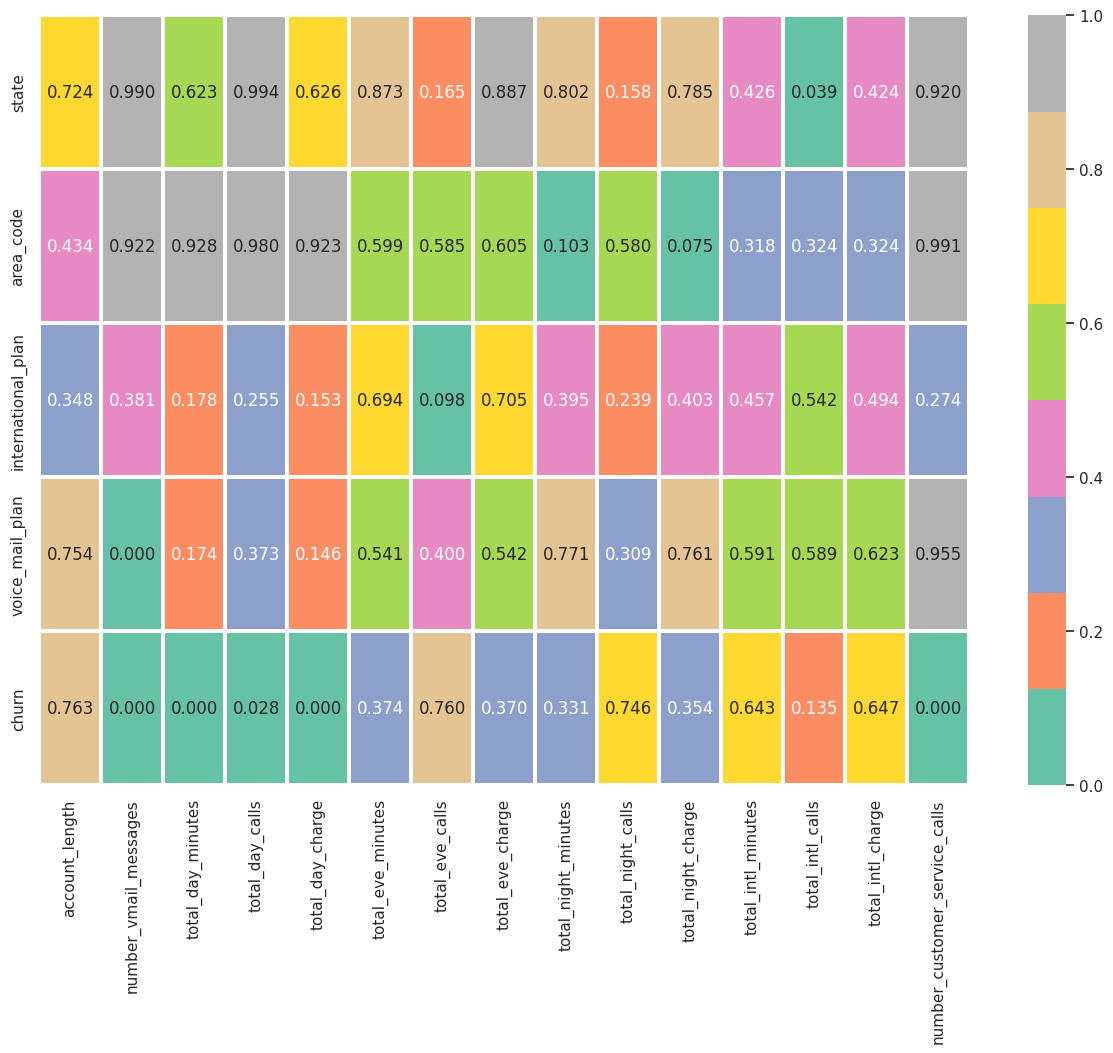

In [20]:
# dependency test: permutation test
## Null hypothesis: All samples come from the same distribution
permutation(df_cleaned, cat_cols, num_cols)

<b>VIF</b>

In [21]:
# VIF
vif = compute_vif(
    df=df_cleaned, 
    num_names=num_cols
)
vif

,name,vif
0,account_length,7.082294e+00
1,number_vmail_messages,1.322519e+00
2,total_day_minutes,1.262232e+08
3,total_day_calls,2.196592e+01
4,total_day_charge,1.262270e+08
5,total_eve_minutes,3.710726e+07
6,total_eve_calls,2.175116e+01
7,total_eve_charge,3.710815e+07
8,total_night_minutes,1.057620e+07
9,total_night_calls,2.137085e+01


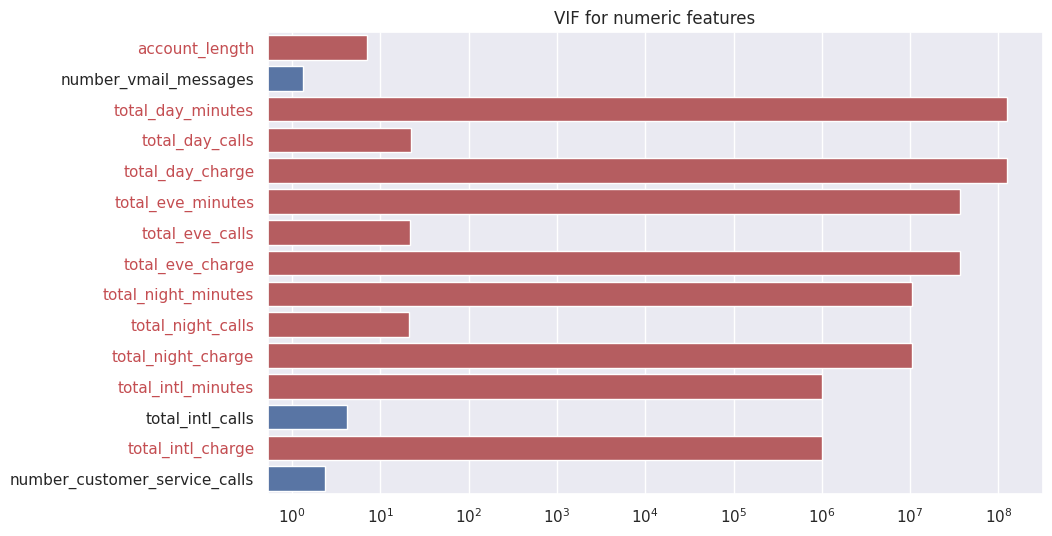

In [22]:
# high VIF
##
mask = vif['vif'] >= 5
high_vif_names = vif[mask]['name'].tolist()
colors = [
    sns.color_palette()[3] if (name in high_vif_names) else sns.color_palette()[0] \
        for name in vif['name'].tolist()
]

##
g = sns.barplot(
    data=vif, 
    x='vif', y='name',
    hue='name',
    orient='h', 
    palette=colors
)
for tick in g.get_yticklabels():
    if tick.get_text() in high_vif_names:
        tick.set_color('r')

g.set_xscale('log')
g.set_title('VIF for numeric features')
g.set_xlabel(None); g.set_ylabel(None)

plt.show()

## Conclusion: can apply PCA

<b>Storing</b>

In [23]:
df_cleaned.to_csv('../../dataset/cleaned/train.csv', index=False)